# Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import os,random
import sys, math, cmath
from time import time
from IPython.display import Markdown, display
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Getting the Data 

In [2]:
with open("RML2016.10a_dict.pkl",'rb') as f:
    Xd = pickle.load(f,encoding='latin1')

#we tell pickle.load() how to convert Python bytestring data to Python 3 strings,
#or you can tell pickle to leave them as bytes.Setting the encoding to latin1 allows you to import the data directly

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
# in map(function, input) format, input = Xd.keys(); we feed to variable x, one key at a time
# then we apply another map; from above, we got a list = [(mod type, SNR)]
# so to each pair; when we do (mod type, SNR)[0] we get the mod type; (mod type, SNR)[1] gives the SNR value
print('**Original dataset**')
print("Dataset has modulation types", mods)
print("and SNR values", snrs)

**Original dataset**
Dataset has modulation types ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
and SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
print(Xd)

{('QPSK', 2): array([[[-0.00590147, -0.00234582, -0.00074506, ..., -0.00326824,
         -0.00304144,  0.00569031],
        [-0.00779554, -0.00781637, -0.00401967, ...,  0.01032196,
          0.00841506,  0.00544548]],

       [[ 0.00503262,  0.0009438 , -0.00189324, ...,  0.00710436,
          0.00647364,  0.00527375],
        [-0.00399943,  0.00161782,  0.00536932, ..., -0.00674945,
          0.00022403, -0.00185736]],

       [[ 0.00523907,  0.00738907,  0.00727646, ..., -0.00567421,
         -0.00974218, -0.01044694],
        [ 0.00419956,  0.0073807 ,  0.00528897, ..., -0.00246656,
          0.00416547, -0.00496793]],

       ...,

       [[ 0.0026172 ,  0.00298624,  0.00437732, ..., -0.00955281,
         -0.00808954, -0.00061479],
        [ 0.00322034,  0.00341152,  0.00447983, ...,  0.00353227,
          0.00287296,  0.00412169]],

       [[-0.00764636, -0.00967675, -0.00678905, ..., -0.00210244,
         -0.00629975, -0.00922944],
        [ 0.00805844,  0.00562819,  0.00702108,

# Separate Training and Test Samples

In [4]:
#Check samples assigned to keys - each (mod, SNR) pair in dictionary

print('**Samples in dataset**')
array_shape = []
print("Dictionary contains", len(Xd), "keys, meaning",len(Xd),"(mod, SNR) pairs" )
for k,v in Xd.items():
    array_shape.append(v.shape)
print("Each key or (mod,SNR) pair is assigned",set(array_shape), "array")
print("This results in a total of",array_shape[0][0], "samples per (mod, SNR) pair, with each sample a",
      array_shape[0][1:3], "array")

**Samples in dataset**
Dictionary contains 220 keys, meaning 220 (mod, SNR) pairs
Each key or (mod,SNR) pair is assigned {(1000, 2, 128)} array
This results in a total of 1000 samples per (mod, SNR) pair, with each sample a (2, 128) array


In [5]:
#Separate samples for training and test sets

from sklearn.utils import shuffle

print('**Separate samples for training and testing**')

Xd_shuffled = dict()

#Randomize the samples assigned to each key
# we take each key: (mod type, snr) pair, and shuffle the samples within this group of values
for k,v in Xd.items():
        v = shuffle(v, random_state=0)
        Xd_shuffled.update({k : v})
# So Xd_shuffled is just Xd_digital with samples belonging to each key shuffled
#set train:test set ratio
train_test = 0.5
dict_test = dict()
dict_train = dict()
test_array_shape = []
train_array_shape = []

#extract the first 'train_test' fraction of samples to form test set and the rest to form training set
for k,v in Xd_shuffled.items():
        dict_test.update({k : v[:int(v.shape[0]*0.5), :]})
        dict_train.update({k : v[int(v.shape[0]*0.5):, :]})
# Take each (mod type, SNR) key. From these 1000 samples assigned to the key, take the first half and put them in test set
# (we already shuffled these samples earlier)

#check samples assgined to each key in dictionary dict_test and dict_train
for k,v in dict_test.items(): test_array_shape.append(v.shape)
for k,v in dict_train.items(): train_array_shape.append(v.shape)

print("Training:Test set ratio = ", train_test)
print("Each key in training set is assigned",set(train_array_shape), "array")
print("Each key in test set is assigned",set(test_array_shape), "array")
print("This results in:")
print("      training set: a total of",train_array_shape[0][0], "samples per (mod, SNR) pair")
print("      test set: a total of",test_array_shape[0][0], "samples per (mod, SNR) pair")

**Separate samples for training and testing**
Training:Test set ratio =  0.5
Each key in training set is assigned {(500, 2, 128)} array
Each key in test set is assigned {(500, 2, 128)} array
This results in:
      training set: a total of 500 samples per (mod, SNR) pair
      test set: a total of 500 samples per (mod, SNR) pair


In [6]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dict_train.keys())))), [1,0])
X_train = []
labels_train = []
for mod in mods:
    for snr in snrs:
        X_train.append(dict_train[(mod,snr)])
        for i in range(dict_train[(mod,snr)].shape[0]):
            labels_train.append((mod,snr))
X_train = np.vstack(X_train)
n_samples_train = X_train.shape[0]
y_train = np.array(list(map(lambda x: mods.index(labels_train[x][0]), range(n_samples_train))))

print("**Training data (raw data)**")
print(X_train.shape,"training data, ", y_train.shape, "labels")


**Training data (raw data)**
(110000, 2, 128) training data,  (110000,) labels


# First 16 features based on 0 cyclic time lag

Design features to transform raw data- each sample (2, 128) to feature vector of length 16

In [7]:
#Form expert features

def form_features(X):

    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample

    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column])
                 for samp_num in range(n_samples) for column in range(vec_len)]

    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])
    X_complex_sqr = np.square(X_complex)
    X_complex_angl = np.angle(X_complex)

    #Form features: set of 16 expert features based on 0 cyclic time lag

    dict_16features = {}

    #Feature 1
    dict_16features['f1'] = np.array([np.mean(X_complex, axis=1)]).T

    #Feature 2
    dict_16features['f2'] = np.array([np.mean(abs(X_complex),axis = 1)]).T

    #Feature 3
    dict_16features['f3'] = np.array([np.mean(X_complex_angl, axis = 1)]).T

    #Feature 4
    dict_16features['f4'] = np.array([np.mean(abs(X_complex_angl), axis = 1)]).T

    #Feature 5
    dict_16features['f5'] = np.array([np.mean(X_complex_sqr, axis = 1)]).T
    #Feature 6
    dict_16features['f6'] = np.array([np.mean(np.square(abs(X_complex)), axis = 1)]).T

    #Feature 7
    dict_16features['f7'] = np.array([np.mean(np.square(X_complex_angl), axis = 1)]).T

    #Feature 8
    dict_16features['f8'] = np.array([np.mean(np.square(abs(X_complex_angl)), axis = 1)]).T

    #Feature 9
    dict_16features['f9'] = np.array([(np.mean(X_complex_sqr,axis = 1)) -
                   ((1/vec_len**2)*np.square(np.sum(X_complex, axis = 1)))]).T

    #Feature 10
    dict_16features['f10'] = np.array([(np.mean(np.square(abs(X_complex)), axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex), axis = 1)))]).T

    #Feature 11
    dict_16features['f11'] = np.array([(np.mean(np.square(X_complex_angl),axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(X_complex_angl, axis = 1)))]).T

    #Feature 12
    dict_16features['f12'] = np.array([(np.mean(np.square(abs(X_complex_angl)), axis = 1)) -
                    ((1/vec_len**2)* np.square(np.sum(abs(X_complex_angl), axis = 1)))]).T

    #Feature 13
    dict_16features['f13'] = np.array([(np.mean(np.power(X_complex,4), axis = 1)) -
                    ((1/vec_len**2)*(np.sum(X_complex_sqr,1))**2)]).T

    #Feature 14
    dict_16features['f14'] = np.array([(np.mean(np.power(abs(X_complex),4), axis = 1)) -
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex)), axis = 1))**2)]).T

    #Feature 15
    dict_16features['f15'] = np.array([(np.mean(np.power(X_complex_angl,4), axis =1)) -
                   ((1/vec_len**2)*(np.sum(np.square(X_complex_angl),axis = 1))**2)]).T
     #Feature 16
    dict_16features['f16'] = np.array([(np.mean(np.power(abs(X_complex_angl),4), axis =1) -
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_angl)),axis = 1))**2))]).T

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))

    return X_16

In [8]:
#Preprocess the training data

#shuffle the samples
X_train, y_train = shuffle(X_train, y_train)

#form features
X_16_train = form_features(X_train)

#standardize the features
sc = StandardScaler()
sc.fit(X_16_train)
X_train_std = sc.transform(X_16_train)

print("**Training data after preprocessing**")
print("           - samples have", X_train_std.shape[1], "features")
print(X_train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 16 features
(110000, 16) training data,  (110000,) labels


# Create features for the test data

Use the same function for creating the test set. But unlike the training set, we keep track of the SNR for each sample in case of test set. This is because the performance/ accuracy of the trained ML algorithm depends on the SNR of the signal, and later an SNR vs. accuracy plot depicts how the algorithm does on samples corresponding to various SNRs.

In [9]:
#Form and preprocess test data

# new defaultdict with keys = SNR values and values = (2,128) samples
test_data = defaultdict(list)
test_labels = defaultdict(list)

# Extract all samples corresponding to each SNR value
# dict_test had keys of the form (mod type, SNR); new dict test_data has keys (SNR)
def form_test_data(snr):
    for k,v in dict_test.items():
        if k[1] == snr:
            test_data[snr].append(v)
            for x in range(v.shape[0]):
                test_labels[snr].append(k[0])
    test_data[snr] = np.vstack(test_data[snr])
    test_labels[snr] = np.vstack(test_labels[snr])
    n_samples_test = test_data[snr].shape[0]
    test_labels[snr] = np.array(list(map(lambda x: mods.index(test_labels[snr][x]), range(n_samples_test))))
    return test_data[snr], test_labels[snr]

X_test = defaultdict(list)
X_test16 = defaultdict(list)
y_test = defaultdict(list)
X_test_std = defaultdict(list)

# Extract samples and labels for each SNR
for snr in snrs:
    data, labels = form_test_data(snr)     # extract all samples belonging to this SNR, from dict_test
    X_test[snr].append(data)
    X_test[snr] = np.vstack(X_test[snr])
    y_test[snr].append(labels)             # extract the corresponding labels belonging to this SNR, from dict_test
    y_test[snr] = np.hstack(y_test[snr])
    X_test[snr], y_test[snr] = shuffle(X_test[snr], y_test[snr])  #shuffle the samples (2, 128)
    X_test16[snr] = form_features(X_test[snr])   #form features; each sample is now (16,) feature vector
    X_test_std[snr] = sc.transform(X_test16[snr])    #standardize the features

print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_test_std[18].shape, "arrays for SNR values", snrs)

**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (5500, 16) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


# Store variables in Jupyter's database

In [10]:
%store snrs
%store X_train_std
%store X_test_std
%store y_train
%store y_test

Stored 'snrs' (list)
Stored 'X_train_std' (ndarray)
Stored 'X_test_std' (defaultdict)
Stored 'y_train' (ndarray)
Stored 'y_test' (defaultdict)


# Next 16 features based on 8 cyclic time lag

Design next 16 features to transform raw data- each sample (2, 128) to feature vector of length 16 and then conmbine the previous 16 and these 16 features to form feature set consisting of 32 features

preprocessing or transformation involves considering a time lag of 8 samples in the signal. In other words, for each sample in the original signal, you may create new features by looking at the values of the signal at 8 time points before and after the current sample.

In [11]:
#Form expert features

def form_next16_features(X):

    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample

    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column])
                 for samp_num in range(n_samples) for column in range(vec_len)]

    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])

    #Form array to use in features based on 8 cyclic time lag

    X_complex_8lag = np.zeros((X_complex.shape), dtype=complex)
    for samp_num in range(n_samples):
        for clmn in range(vec_len):
            shift_by = (clmn + 8)%vec_len
            X_complex_8lag[samp_num,clmn] = (X_complex[samp_num,clmn])*(X_complex[samp_num,shift_by])

    X_complex8_sqr = np.square(X_complex_8lag)
    X_complex8_angl = np.angle(X_complex_8lag)

    #16 expert features based on 8 cyclic time lag

    dict_16features = {}
     #Feature 17
    dict_16features['f17'] = np.array([np.mean(X_complex_8lag, axis = 1)]).T

    #Feature 18
    dict_16features['f18'] = np.array([np.mean(abs(X_complex_8lag),axis = 1)]).T

    #Feature 19
    dict_16features['f19'] = np.array([np.mean(X_complex8_angl, axis = 1)]).T

    #Feature 20
    dict_16features['f20'] = np.array([np.mean(abs(X_complex8_angl), axis = 1)]).T

    #Feature 21
    dict_16features['f21'] = np.array([np.mean(X_complex8_sqr, axis = 1)]).T

    #Feature 22
    dict_16features['f22'] = np.array([np.mean(np.square(abs(X_complex_8lag)), axis = 1)]).T

    #Feature 23
    dict_16features['f23'] = np.array([np.mean(np.square(X_complex8_angl), axis = 1)]).T

    #Feature 24
    dict_16features['f24'] = np.array([np.mean(np.square(abs(X_complex8_angl)), axis = 1)]).T

    #Feature 25
    dict_16features['f25'] = np.array([(np.mean(X_complex8_sqr,axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(X_complex_8lag, axis = 1)))]).T

    #Feature 26
    dict_16features['f26'] = np.array([(np.mean(np.square(abs(X_complex_8lag)), axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex_8lag), axis = 1)))]).T

    #Feature 27
    dict_16features['f27'] = np.array([(np.mean(np.square(X_complex8_angl),axis = 1)) -
              ((1/vec_len**2)*np.square(np.sum(X_complex8_angl, axis = 1)))]).T
    #Feature 28
    dict_16features['f28'] = np.array([(np.mean(np.square(abs(X_complex8_angl)), axis = 1)) -
             ((1/vec_len**2)* np.square(np.sum(abs(X_complex8_angl), axis = 1)))]).T

    #Feature 29
    dict_16features['f29'] = np.array([(np.mean(np.power(X_complex_8lag,4), axis = 1)) -
                    ((1/vec_len**2)*(np.sum(X_complex8_sqr,1))**2)]).T

    #Feature 30
    dict_16features['f30'] = np.array([(np.mean(np.power(abs(X_complex_8lag),4), axis = 1)) -
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_8lag)), axis = 1))**2)]).T

    #Feature 31
    dict_16features['f31'] = np.array([((1/vec_len)* np.sum(np.power(X_complex8_angl,4), axis =1)) -
                     ((1/vec_len**2)*(np.sum(np.square(X_complex8_angl),axis = 1))**2)]).T

    #Feature 32
    dict_16features['f32'] = np.array([(np.mean(np.power(abs(X_complex8_angl),4), axis =1) -
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex8_angl)),axis = 1))**2))]).T

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))

    return X_16

In [12]:
#Preprocess the training data

#form features
X_next16_train = form_next16_features(X_train)

# combine the previous 16 features with these next 16 features, to create (n_samples, 32) data
X_32_train = np.concatenate((X_16_train, X_next16_train), axis = 1)

#standardize the features
sc = StandardScaler()
sc.fit(X_32_train)
X_32train_std = sc.transform(X_32_train)

print("**Training data after preprocessing**")
print("           - samples have", X_32train_std.shape[1], "features")
print(X_32train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 32 features
(110000, 32) training data,  (110000,) labels


In [13]:
#Form and preprocess test data

X_next16test = defaultdict(list)
X_32test_std = defaultdict(list)
X_32test = defaultdict(list)

for snr in snrs:
    X_next16test[snr] = form_next16_features(X_test[snr])   # form the next 16 features
    # concatenate the previous 16 and these next 16 features, so total 32 features
    X_32test[snr] = np.concatenate((X_test16[snr], X_next16test[snr]), axis = 1)
    X_32test_std[snr] = sc.transform(X_32test[snr])    #standardize the features

print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_32test_std[18].shape, "arrays for SNR values", snrs)

**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (5500, 32) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [14]:
y_32_train = y_train
y_32_test = y_test

# Store variables in Jupyter's database

In [15]:
%store X_32train_std
%store X_32test_std
%store y_32_train
%store y_32_test

Stored 'X_32train_std' (ndarray)
Stored 'X_32test_std' (defaultdict)
Stored 'y_32_train' (ndarray)
Stored 'y_32_test' (defaultdict)


# View all stored variables

In [16]:
%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {-20: array([[-0.83511
X_32train_std             -> array([[-0.91864304,  0.62978739, -0.689897  , ...
X_test_std                -> defaultdict(<class 'list'>, {-20: array([[-0.83511
X_train_std               -> array([[-0.91864304,  0.62978739, -0.689897  , ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {-20: array([ 6,  7,  
y_32_train                -> array([9, 7, 6, ..., 3, 4, 5])
y_test                    -> defaultdict(<class 'list'>, {-20: array([ 6,  7,  
y_train                   -> array([9, 7, 6, ..., 3, 4, 5])


# K-Nearest Neighbor Model

# Train and test the classifier

In [84]:
#Train the classifier

from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [18,19,20], 'weights':['uniform','distance']}

grid_search_cv = GridSearchCV(KNeighborsClassifier(algorithm='auto'), params, verbose=1)

start = time()
grid_search_cv.fit(X_32train_std, y_32_train)
print("Grid search took %.2f minutes "%((time() - start)//60))
print("   ")
print("Result of grid search, best estimator:")
print(grid_search_cv.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid search took 17.00 minutes 
   
Result of grid search, best estimator:
KNeighborsClassifier(n_neighbors=20, weights='distance')


In [85]:
#Test the classifier

import collections

y_pred = defaultdict(list)
accuracy = defaultdict(list)

print("*Test the classifier")
print("   ")
for snr in snrs:
    y_pred[snr] = grid_search_cv.predict(X_32test_std[snr])
    accuracy[snr] = metrics.accuracy_score(y_32_test[snr], y_pred[snr])
    print("k-Nearest Neighbor's Accuracy on %d dB SNR samples = "%(snr), accuracy[snr])   
    
accuracy = collections.OrderedDict(sorted(accuracy.items()))  #sort by ascending SNR values

*Test the classifier
   
k-Nearest Neighbor's Accuracy on -20 dB SNR samples =  0.0890909090909091
k-Nearest Neighbor's Accuracy on -18 dB SNR samples =  0.08781818181818182
k-Nearest Neighbor's Accuracy on -16 dB SNR samples =  0.09345454545454546
k-Nearest Neighbor's Accuracy on -14 dB SNR samples =  0.09854545454545455
k-Nearest Neighbor's Accuracy on -12 dB SNR samples =  0.10690909090909091
k-Nearest Neighbor's Accuracy on -10 dB SNR samples =  0.13436363636363635
k-Nearest Neighbor's Accuracy on -8 dB SNR samples =  0.20745454545454545
k-Nearest Neighbor's Accuracy on -6 dB SNR samples =  0.29672727272727273
k-Nearest Neighbor's Accuracy on -4 dB SNR samples =  0.3487272727272727
k-Nearest Neighbor's Accuracy on -2 dB SNR samples =  0.3996363636363636
k-Nearest Neighbor's Accuracy on 0 dB SNR samples =  0.48418181818181816
k-Nearest Neighbor's Accuracy on 2 dB SNR samples =  0.5854545454545454
k-Nearest Neighbor's Accuracy on 4 dB SNR samples =  0.6343636363636364
k-Nearest Neigh

# Visualize classifier performance

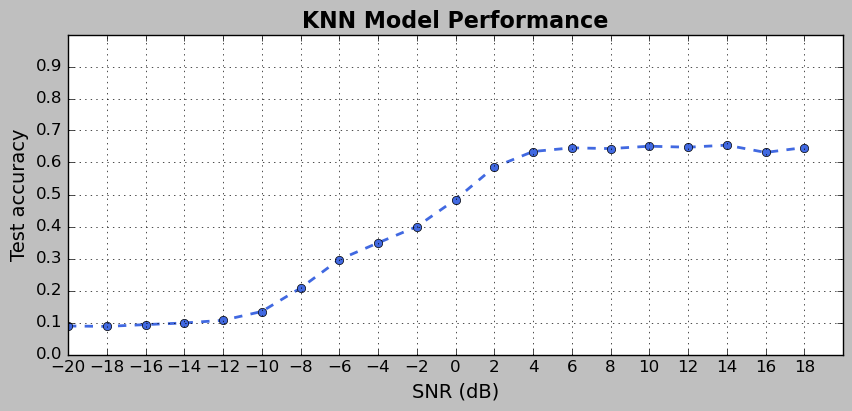

In [86]:
plt.style.use('classic')

fig = plt.figure(figsize=(10, 4), dpi=100)
x = snrs
y1 = list(accuracy.values())
plt.plot(x, y1, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('KNN Model Performance', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

In [90]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import pandas as pd
s= snrs[9:]
classes = ['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM']
y_predicted = grid_search_cv.predict(X_32test_std[18])
conf_matrix = confusion_matrix(y_predicted, y_32_test[18])
df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix without normalization")
print(df)

Confusion Matrix without normalization
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK     251       0      29     1      2     6     1     73     55   181   
AM-DSB     1     382       5     0      0     0     1      5      9     0   
AM-SSB     0       0     307     3      0     0     3     10      9     1   
BPSK       2       0      35   490      0     0    18      4      9     3   
CPFSK     29       0      28     0    486    66     0      7      9    34   
GFSK      30       0      21     1     11   406     0     11     10    27   
PAM4       1       0      20     4      0     0   475     10      3     0   
QAM16     15       0      12     0      0     0     0    149    153    20   
QAM64     24       0       4     0      0     0     2    181    200    21   
QPSK     147       0      33     1      1     3     0     47     39   213   
WBFM       0     118       6     0      0    19     0      3      4     0   

        WBFM  
8PSK       0  
AM-DSB

In [93]:
#Normalize the matrix

conf_matrix1= conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix1 = conf_matrix1.round(decimals = 2)

df = pd.DataFrame(data = conf_matrix1, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)



Confusion Matrix
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK    0.42    0.00    0.05  0.00   0.00  0.01  0.00   0.12   0.09  0.30   
AM-DSB  0.00    0.58    0.01  0.00   0.00  0.00  0.00   0.01   0.01  0.00   
AM-SSB  0.00    0.00    0.92  0.01   0.00  0.00  0.01   0.03   0.03  0.00   
BPSK    0.00    0.00    0.06  0.87   0.00  0.00  0.03   0.01   0.02  0.01   
CPFSK   0.04    0.00    0.04  0.00   0.74  0.10  0.00   0.01   0.01  0.05   
GFSK    0.05    0.00    0.04  0.00   0.02  0.72  0.00   0.02   0.02  0.05   
PAM4    0.00    0.00    0.04  0.01   0.00  0.00  0.93   0.02   0.01  0.00   
QAM16   0.04    0.00    0.03  0.00   0.00  0.00  0.00   0.43   0.44  0.06   
QAM64   0.06    0.00    0.01  0.00   0.00  0.00  0.00   0.42   0.46  0.05   
QPSK    0.30    0.00    0.07  0.00   0.00  0.01  0.00   0.10   0.08  0.44   
WBFM    0.00    0.34    0.02  0.00   0.00  0.05  0.00   0.01   0.01  0.00   

        WBFM  
8PSK    0.00  
AM-DSB  0.39  
AM-SSB  0.00 

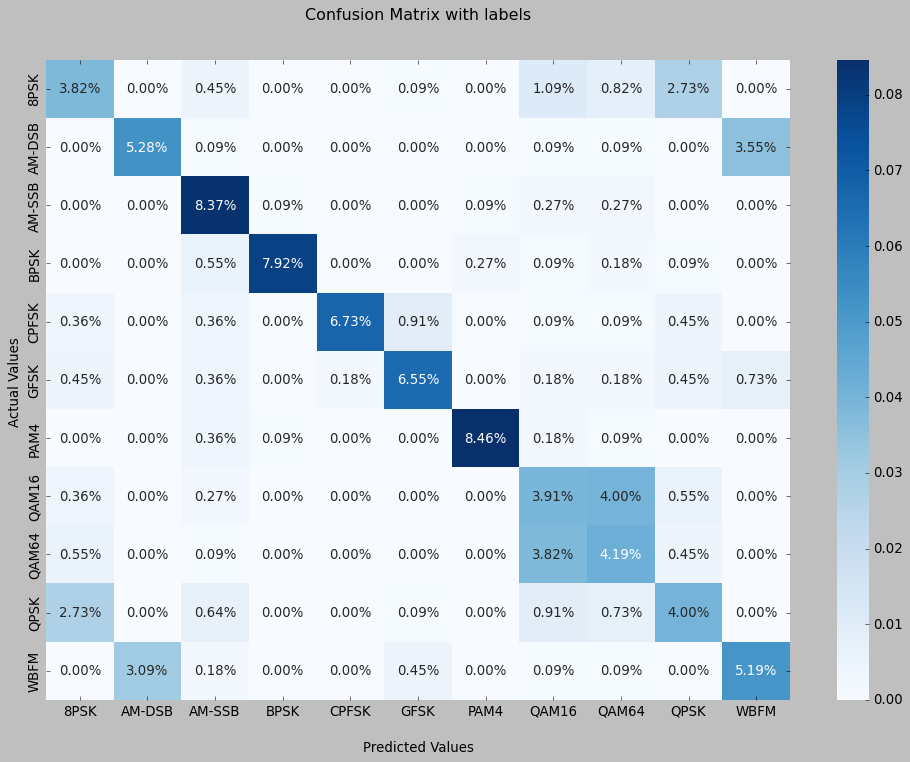

In [94]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(15,10))
ax = sns.heatmap(conf_matrix1/np.sum(conf_matrix1), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM'])
ax.yaxis.set_ticklabels(['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Decision Tree Classifier Model

# Train and test the classifier

In [95]:
#Train the classifier

params = {'max_depth': list(range(9,18)),'max_leaf_nodes': list(range(50, 150)), 'min_samples_split': [2,3,4],
          'max_features': [None,'auto','sqrt','log2'], 'criterion':['gini', 'entropy']}

rand_search_cv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=0)

start = time()
print("Train decision tree classifier - randomized search for parameter optimization")
rand_search_cv.fit(X_32train_std, y_32_train)
print("Randomized search took %.2f minutes "%((time() - start)//60))
print("   ")
print("Result of randomized search:")
print(rand_search_cv.best_estimator_)

Train decision tree classifier - randomized search for parameter optimization
Randomized search took 1.00 minutes 
   
Result of randomized search:
DecisionTreeClassifier(max_depth=13, max_leaf_nodes=105, min_samples_split=4,
                       random_state=42)


In [96]:
#Test the classifier

import collections

y_pred = defaultdict(list)
accuracy = defaultdict(list)

print("Test the classifier")
print(" ")
for snr in snrs:
    y_pred[snr] = rand_search_cv.predict(X_32test_std[snr])
    accuracy[snr] = metrics.accuracy_score(y_32_test[snr], y_pred[snr])
    print("Decision Tree's accuracy on %d dB SNR samples = "%(snr), accuracy[snr])   
    
accuracy = collections.OrderedDict(sorted(accuracy.items()))  #sort by ascending SNR value

Test the classifier
 
Decision Tree's accuracy on -20 dB SNR samples =  0.09381818181818181
Decision Tree's accuracy on -18 dB SNR samples =  0.09363636363636364
Decision Tree's accuracy on -16 dB SNR samples =  0.09254545454545454
Decision Tree's accuracy on -14 dB SNR samples =  0.09654545454545455
Decision Tree's accuracy on -12 dB SNR samples =  0.11127272727272727
Decision Tree's accuracy on -10 dB SNR samples =  0.14636363636363636
Decision Tree's accuracy on -8 dB SNR samples =  0.25145454545454543
Decision Tree's accuracy on -6 dB SNR samples =  0.31054545454545457
Decision Tree's accuracy on -4 dB SNR samples =  0.34563636363636363
Decision Tree's accuracy on -2 dB SNR samples =  0.42218181818181816
Decision Tree's accuracy on 0 dB SNR samples =  0.5454545454545454
Decision Tree's accuracy on 2 dB SNR samples =  0.6338181818181818
Decision Tree's accuracy on 4 dB SNR samples =  0.7612727272727273
Decision Tree's accuracy on 6 dB SNR samples =  0.8007272727272727
Decision Tree'

# Visualize classifier performance

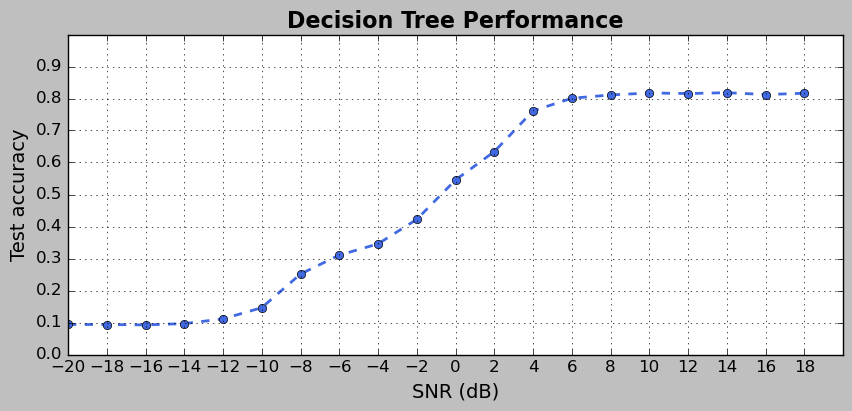

In [97]:
plt.style.use('classic')

fig = plt.figure(figsize=(10, 4), dpi=100)
x = snrs
y2 = list(accuracy.values())
plt.plot(x, y2, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('Decision Tree Performance', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

In [98]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import pandas as pd

classes = ['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM']
y_predicted = rand_search_cv.predict(X_32test_std[18])
conf_matrix = confusion_matrix(y_predicted, y_32_test[18]) 

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix of Decision Tree Classifier:")
print(df)

Confusion Matrix of Decision Tree Classifier:
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK     445       0       5     0      0     0     0     52     44    11   
AM-DSB     0     500       0     0      0     0     0      6      5     0   
AM-SSB     2       0     475     5      0     0     4      5     10     1   
BPSK       1       0       0   475      0     0    12      2      0     2   
CPFSK      8       0       0     0    494     2     0     10      7     0   
GFSK       9       0       6     0      6   493     0      4      6     4   
PAM4       2       0       5    20      0     0   481     10     10     3   
QAM16      7       0       0     0      0     0     0    107     69     5   
QAM64      6       0       9     0      0     0     0    285    346     4   
QPSK      19       0       0     0      0     0     0     19      3   470   
WBFM       1       0       0     0      0     5     3      0      0     0   

        WBFM  
8PSK       0  

In [99]:
#Normalize the matrix

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)



Confusion Matrix
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK    0.80    0.00    0.01  0.00   0.00  0.00  0.00   0.09   0.08  0.02   
AM-DSB  0.00    0.62    0.00  0.00   0.00  0.00  0.00   0.01   0.01  0.00   
AM-SSB  0.00    0.00    0.95  0.01   0.00  0.00  0.01   0.01   0.02  0.00   
BPSK    0.00    0.00    0.00  0.97   0.00  0.00  0.02   0.00   0.00  0.00   
CPFSK   0.02    0.00    0.00  0.00   0.95  0.00  0.00   0.02   0.01  0.00   
GFSK    0.02    0.00    0.01  0.00   0.01  0.93  0.00   0.01   0.01  0.01   
PAM4    0.00    0.00    0.01  0.04   0.00  0.00  0.91   0.02   0.02  0.01   
QAM16   0.04    0.00    0.00  0.00   0.00  0.00  0.00   0.57   0.37  0.03   
QAM64   0.01    0.00    0.01  0.00   0.00  0.00  0.00   0.44   0.53  0.01   
QPSK    0.04    0.00    0.00  0.00   0.00  0.00  0.00   0.04   0.01  0.92   
WBFM    0.00    0.00    0.00  0.00   0.00  0.02  0.01   0.00   0.00  0.00   

        WBFM  
8PSK    0.00  
AM-DSB  0.36  
AM-SSB  0.00 

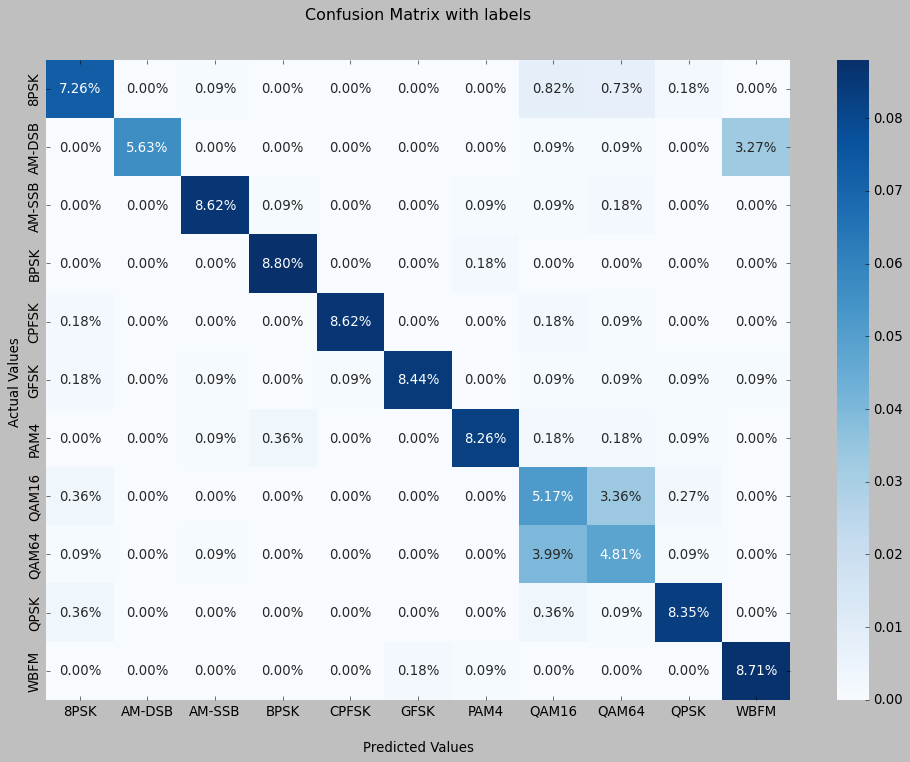

In [100]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(15,10))
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM'])
ax.yaxis.set_ticklabels(['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Bagging and Pasting Classifiers Model

In [101]:
#Train the classifier

bagg_clf = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, n_estimators=400, max_samples=100)
paste_clf = BaggingClassifier(DecisionTreeClassifier(), bootstrap=False, n_estimators=400, max_samples=100)

start = time()
bagg_clf.fit(X_32train_std, y_32_train)  
print("Bagging: training took %.2f seconds"%(time() - start))
print("BaggingClassifier:")
print(bagg_clf)

print(" ")

start = time()
paste_clf.fit(X_32train_std, y_32_train)  
print("Pasting: training took %.2f seconds"%(time() - start))
print("PastingClassifier:")
print(paste_clf)


Bagging: training took 27.97 seconds
BaggingClassifier:
BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=400)
 
Pasting: training took 28.84 seconds
PastingClassifier:
BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=False,
                  max_samples=100, n_estimators=400)


In [102]:
#Test the classifier

import collections

y_pred = defaultdict(list)
accuracy_bagg = defaultdict(list)

print("Test bagging classifier")
print(" ")
for snr in snrs:
    y_pred[snr] = bagg_clf.predict(X_32test_std[snr])
    accuracy_bagg[snr] = metrics.accuracy_score(y_32_test[snr], y_pred[snr])
    print("Accuracy on %d dB SNR samples = "%(snr), accuracy_bagg[snr])   
    
accuracy_bagg = collections.OrderedDict(sorted(accuracy_bagg.items()))  #sort by ascending SNR value

Test bagging classifier
 
Accuracy on -20 dB SNR samples =  0.09163636363636364
Accuracy on -18 dB SNR samples =  0.09018181818181818
Accuracy on -16 dB SNR samples =  0.09363636363636364
Accuracy on -14 dB SNR samples =  0.09636363636363636
Accuracy on -12 dB SNR samples =  0.10763636363636364
Accuracy on -10 dB SNR samples =  0.1370909090909091
Accuracy on -8 dB SNR samples =  0.20127272727272727
Accuracy on -6 dB SNR samples =  0.2843636363636364
Accuracy on -4 dB SNR samples =  0.3663636363636364
Accuracy on -2 dB SNR samples =  0.4198181818181818
Accuracy on 0 dB SNR samples =  0.5025454545454545
Accuracy on 2 dB SNR samples =  0.6438181818181818
Accuracy on 4 dB SNR samples =  0.7454545454545455
Accuracy on 6 dB SNR samples =  0.7596363636363637
Accuracy on 8 dB SNR samples =  0.7649090909090909
Accuracy on 10 dB SNR samples =  0.7721818181818182
Accuracy on 12 dB SNR samples =  0.771090909090909
Accuracy on 14 dB SNR samples =  0.7785454545454545
Accuracy on 16 dB SNR samples = 

In [103]:
#Test the classifier

import collections

y_pred = defaultdict(list)
accuracy_paste = defaultdict(list)

print("Test pasting classifier")
print(" ")
for snr in snrs:
    y_pred[snr] = paste_clf.predict(X_32test_std[snr])
    accuracy_paste[snr] = metrics.accuracy_score(y_32_test[snr], y_pred[snr])
    print("Accuracy on %d dB SNR samples = "%(snr), accuracy_paste[snr])   
    
accuracy_paste = collections.OrderedDict(sorted(accuracy_paste.items()))  #sort by ascending SNR value

Test pasting classifier
 
Accuracy on -20 dB SNR samples =  0.09218181818181818
Accuracy on -18 dB SNR samples =  0.09327272727272727
Accuracy on -16 dB SNR samples =  0.094
Accuracy on -14 dB SNR samples =  0.09436363636363636
Accuracy on -12 dB SNR samples =  0.112
Accuracy on -10 dB SNR samples =  0.138
Accuracy on -8 dB SNR samples =  0.20054545454545455
Accuracy on -6 dB SNR samples =  0.28345454545454546
Accuracy on -4 dB SNR samples =  0.3410909090909091
Accuracy on -2 dB SNR samples =  0.42218181818181816
Accuracy on 0 dB SNR samples =  0.49945454545454543
Accuracy on 2 dB SNR samples =  0.6252727272727273
Accuracy on 4 dB SNR samples =  0.738909090909091
Accuracy on 6 dB SNR samples =  0.768
Accuracy on 8 dB SNR samples =  0.7709090909090909
Accuracy on 10 dB SNR samples =  0.7765454545454545
Accuracy on 12 dB SNR samples =  0.7796363636363637
Accuracy on 14 dB SNR samples =  0.7883636363636364
Accuracy on 16 dB SNR samples =  0.7752727272727272
Accuracy on 18 dB SNR samples =

In [104]:
from sklearn.metrics import confusion_matrix
import pandas as pd

classes = ['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM']
y_predicted = bagg_clf.predict(X_32test_std[18])
conf_matrix = confusion_matrix(y_predicted, y_32_test[18]) 

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix of Bagging Classifier:")
print(df)

Confusion Matrix of Bagging Classifier:
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK     403       0      18     0      0     0     0     38     37     7   
AM-DSB     0     500       1     0      0     0     0      0      0     0   
AM-SSB     1       0     436     5      0     0     4      3      5     1   
BPSK       5       0       1   483      0     0    15     10      9    10   
CPFSK     36       0      11     0    498    53     0      4      6     2   
GFSK      16       0       1     0      1   421     0      2      2     6   
PAM4       3       0       2    11      0     0   481     12     15     3   
QAM16      1       0      14     0      0     0     0    123    128     1   
QAM64      3       0      14     0      0     0     0    250    267    10   
QPSK      32       0       2     0      0     0     0     57     27   460   
WBFM       0       0       0     1      1    26     0      1      4     0   

        WBFM  
8PSK       0  
AM-DS

In [105]:
from sklearn.metrics import confusion_matrix
import pandas as pd

classes = ['8PSK','AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK','WBFM']
y_predicted = paste_clf.predict(X_32test_std[18])
conf_matrix = confusion_matrix(y_predicted, y_32_test[18]) 

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix of Pasting Classifier:")
print(df)

Confusion Matrix of Pasting Classifier:
        8PSK  AM-DSB  AM-SSB  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK  \
8PSK     421       0      16     0      0     0     0     46     42    10   
AM-DSB     0     500       1     0      0     0     0      0      2     0   
AM-SSB     2       0     449     4      0     0     4      3      5     1   
BPSK       5       0       1   483      0     0    16     12      9    10   
CPFSK     28       0       9     1    495    34     0      2      5     3   
GFSK      14       0       0     0      5   441     0      2      4    11   
PAM4       3       0       0    11      0     0   480     15     15     3   
QAM16      2       0      10     0      0     0     0     95     83     6   
QAM64      3       0      11     0      0     0     0    287    313     8   
QPSK      22       0       3     0      0     0     0     37     19   448   
WBFM       0       0       0     1      0    25     0      1      3     0   

        WBFM  
8PSK       0  
AM-DS

# Visualize classifier performance


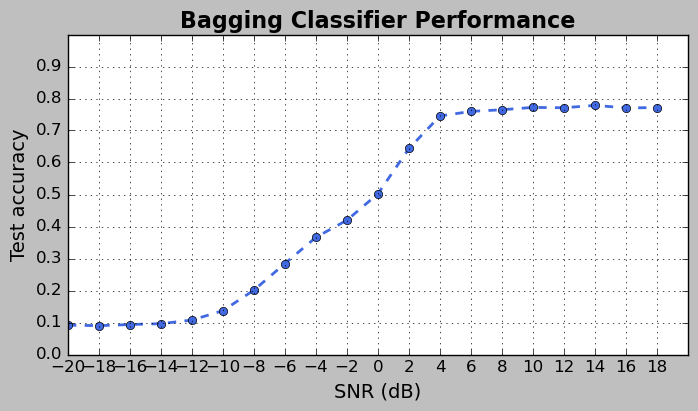

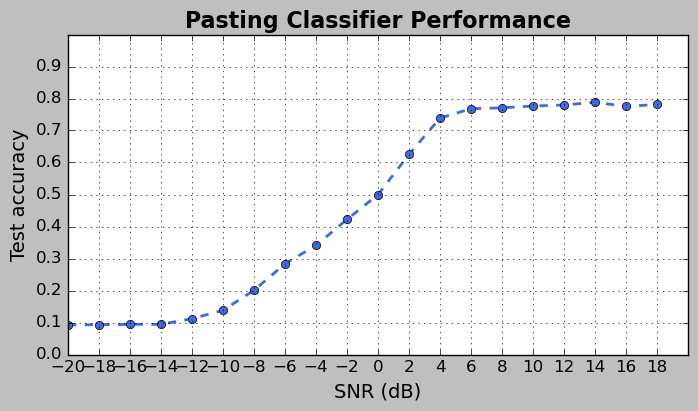

In [106]:
#Visualize the performance 

plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y3 = list(accuracy_bagg.values())
plt.plot(x, y3, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('Bagging Classifier Performance', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()
#----------------------------------------------------------

plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y4 = list(accuracy_paste.values())
plt.plot(x, y4, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('Pasting Classifier Performance', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

# Comparision Of Four Classifiers Through Visualization

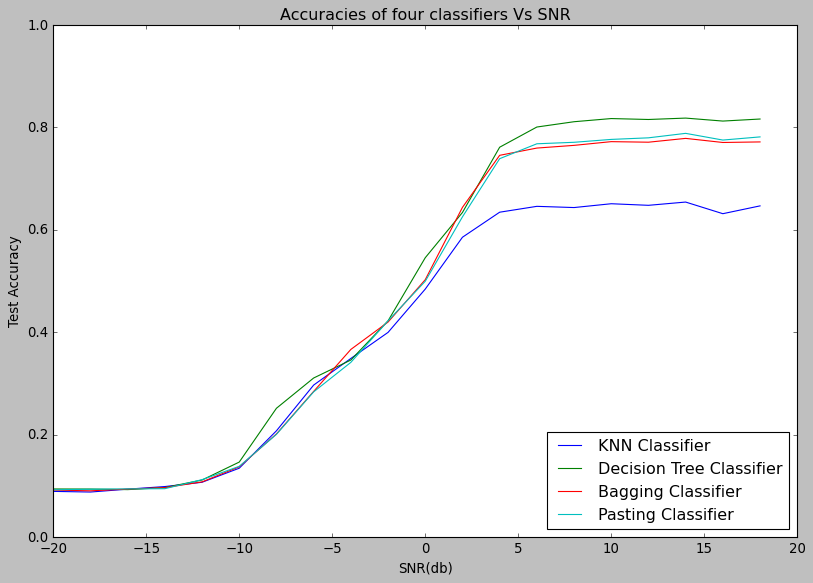

In [107]:
plt.figure(figsize=(12,8))
plt.plot(x,y1,label='KNN Classifier')
plt.plot(x,y2,label='Decision Tree Classifier')
plt.plot(x,y3,label='Bagging Classifier')
plt.plot(x,y4,label='Pasting Classifier')
plt.axis([-20, 20, 0, 1])
plt.title('Accuracies of four classifiers Vs SNR')
plt.xlabel('SNR(db)')
plt.ylabel('Test Accuracy')
plt.legend(loc="lower right")
plt.show( )


# DEEP LEARNING

In [54]:
!pip install tensorflow
!pip install tensorflow==1.14

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==1.14 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==1.14


In [32]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras


import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, MaxPooling1D, Reshape, ZeroPadding2D,LSTM, Conv1DTranspose
from tensorflow.keras.models import Sequential



In [33]:
classes = mods 
classes = np.array(classes)     #  classes list'i array'e dönüştürüldü.
classes = classes.reshape(classes.shape[0], 1)
classes

array([['8PSK'],
       ['AM-DSB'],
       ['AM-SSB'],
       ['BPSK'],
       ['CPFSK'],
       ['GFSK'],
       ['PAM4'],
       ['QAM16'],
       ['QAM64'],
       ['QPSK'],
       ['WBFM']], dtype='<U6')

In [41]:
X=[]
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append(mod)
lbl

['8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 '8PSK',
 

In [45]:
### CLDNN Model ###

layer_in = keras.layers.Input(shape=(128,2))
layer = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=2)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(len(mods), activation='softmax')(layer)

model_cldnn = keras.models.Model(layer_in, layer_out)


model_cldnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 121, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1  (None, 60, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                            

In [58]:
#### Optimizer Stage

###opt = keras.optimizers.Adam(learning_rate = 0.0007, beta_1 = 0.9, beta_2 = 0.99, amsgrad = False)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cldnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]

model_cldnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_cldnn.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    callbacks = [callbacks],
                    epochs=30, batch_size = 32)




Train on 176000 samples, validate on 44000 samples
Epoch 1/30
176000/176000 [==============================] - 485s 3ms/sample - loss: 1.8647 - acc: 0.3014 - val_loss: 1.5683 - val_acc: 0.4071 - lr: 7.0000e-04
Epoch 2/30
176000/176000 [==============================] - 484s 3ms/sample - loss: 1.4832 - acc: 0.4391 - val_loss: 1.3473 - val_acc: 0.4770 - lr: 7.0000e-04
Epoch 3/30
176000/176000 [==============================] - 286s 2ms/sample - loss: 1.3510 - acc: 0.4785 - val_loss: 1.3021 - val_acc: 0.4921 - lr: 7.0000e-04
Epoch 4/30
176000/176000 [==============================] - 224s 1ms/sample - loss: 1.2884 - acc: 0.5020 - val_loss: 1.2578 - val_acc: 0.5130 - lr: 7.0000e-04
Epoch 5/30
176000/176000 [==============================] - 220s 1ms/sample - loss: 1.2466 - acc: 0.5209 - val_loss: 1.2354 - val_acc: 0.5259 - lr: 7.0000e-04
Epoch 6/30
176000/176000 [==============================] - 222s 1ms/sample - loss: 1.2228 - acc: 0.5325 - val_loss: 1.1948 - val_acc: 0.5458 - lr: 7.00

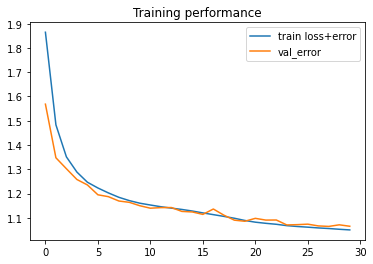

In [59]:
### Loss graph 

plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [60]:
### Confusion matrix oluşturulması 
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

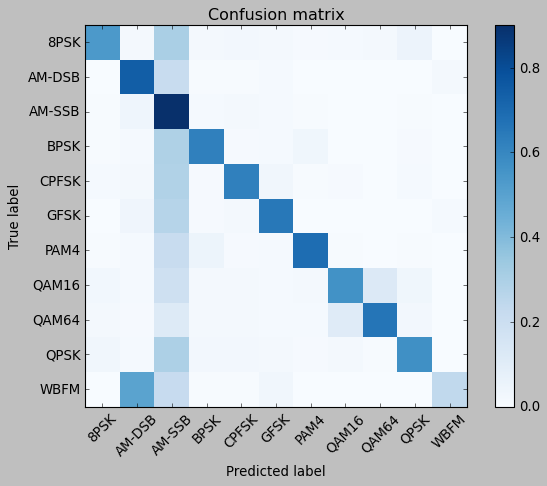

In [109]:
### Plot confusion matrix
test_Y_hat = model_cldnn.predict(X_test, batch_size=32)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#figure(figsize=(10, 8)
plot_confusion_matrix(confnorm, labels=classes)

In [65]:
temp = {}
lb = {}

for i in range(20):
    temp[-20 + (i *2)] = []
    lb[-20 + (i *2)] = []
    
for i in range(20):
    for j in range(11):
        arr = Xd[(classes[j][0] , (-20 + (i *2)))]
        for k in range(len(arr)) : temp [-20 + (i *2 )].append(arr[k])
        for k in range(len(Xd[classes[j][0], -20 + ( i*2)])): lb[-20 + (i*2)].append(classes[j][0])

Overall Accuracy:  0.092
0.092
Overall Accuracy:  0.099
0.099
Overall Accuracy:  0.108
0.108
Overall Accuracy:  0.1265
0.1265
Overall Accuracy:  0.16
0.16
Overall Accuracy:  0.2695
0.2695
Overall Accuracy:  0.4285
0.4285
Overall Accuracy:  0.577
0.577
Overall Accuracy:  0.7325
0.7325
Overall Accuracy:  0.8405
0.8405
Overall Accuracy:  0.8955
0.8955
Overall Accuracy:  0.918
0.918
Overall Accuracy:  0.917
0.917
Overall Accuracy:  0.911
0.911
Overall Accuracy:  0.917
0.917
Overall Accuracy:  0.924
0.924
Overall Accuracy:  0.9265
0.9265
Overall Accuracy:  0.917
0.917
Overall Accuracy:  0.914
0.914
Overall Accuracy:  0.912
0.912


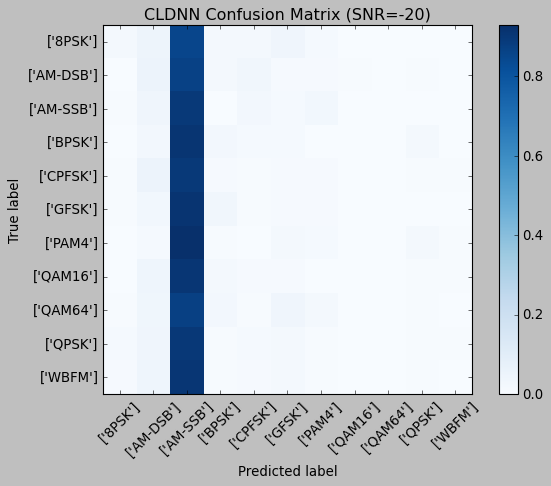

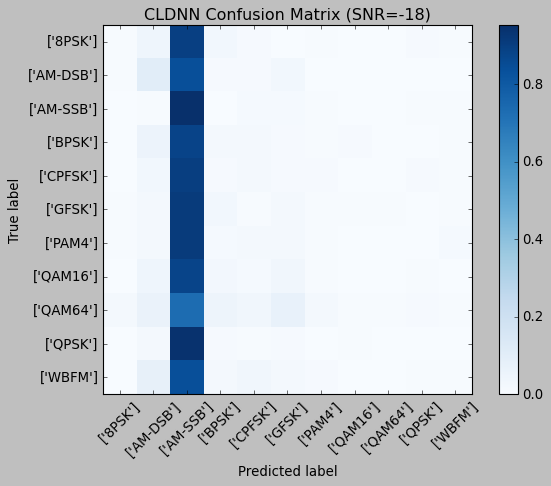

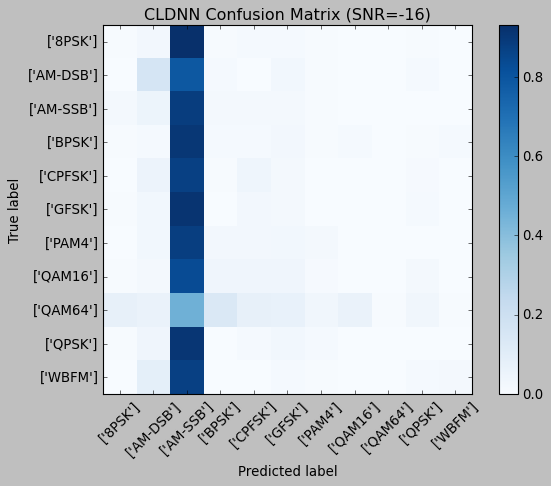

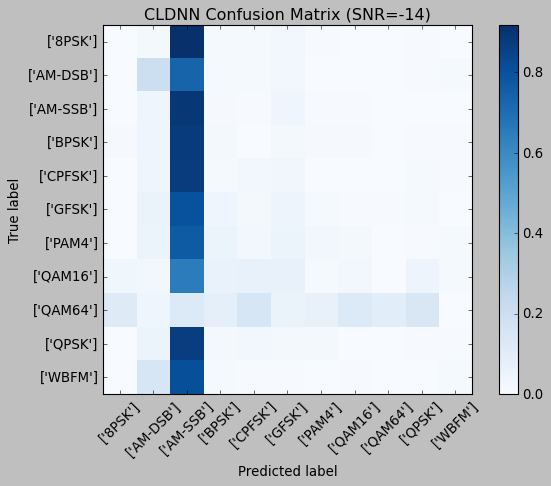

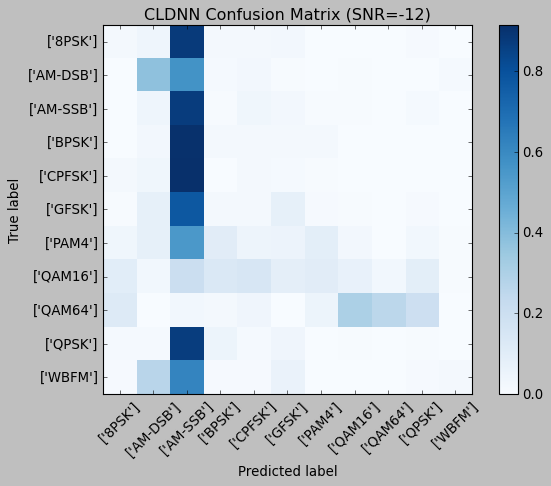

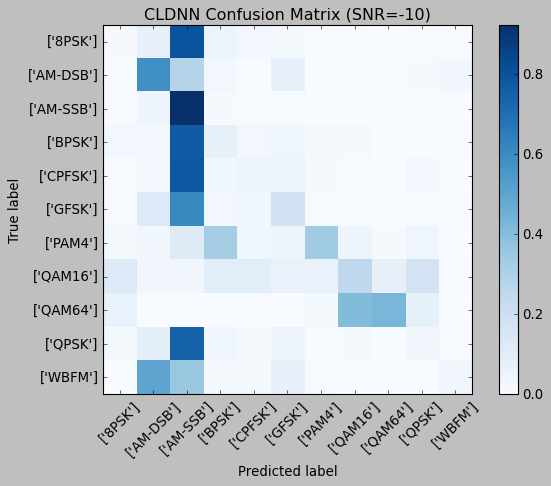

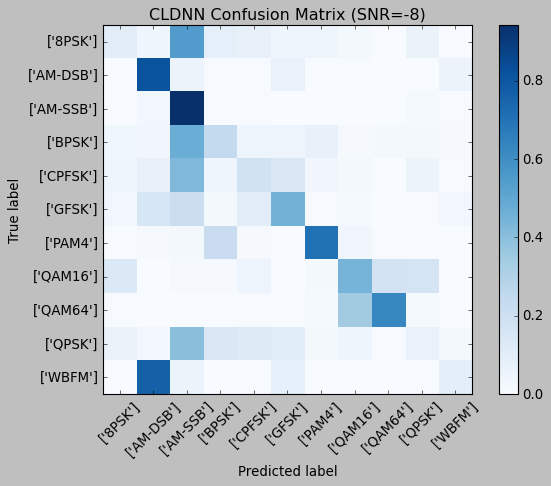

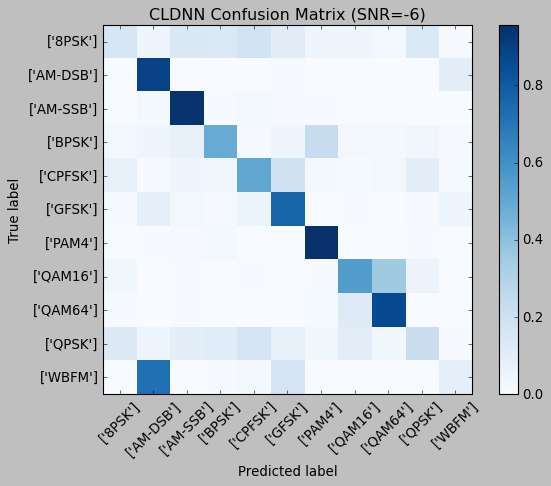

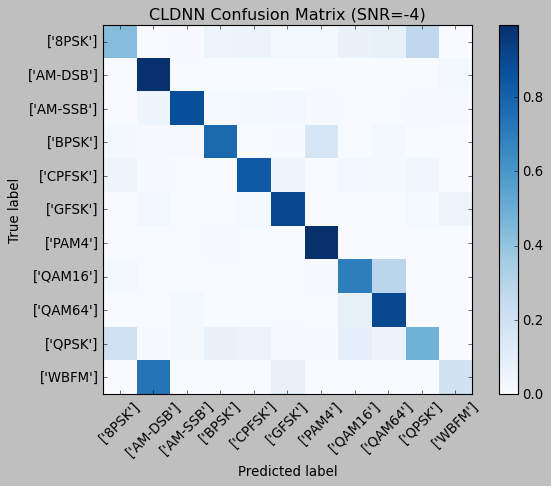

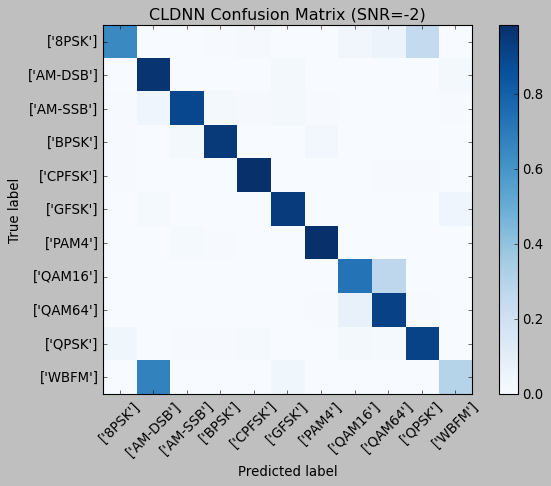

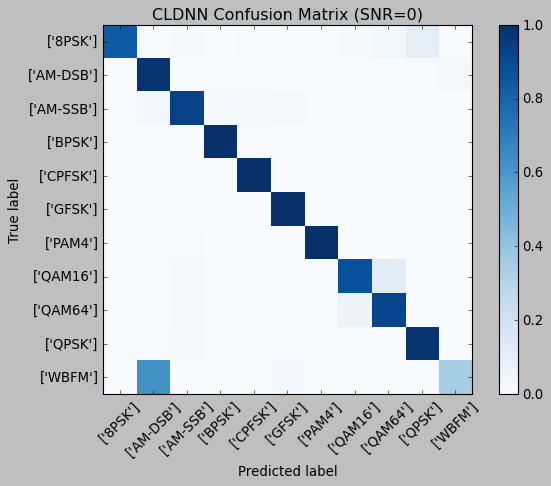

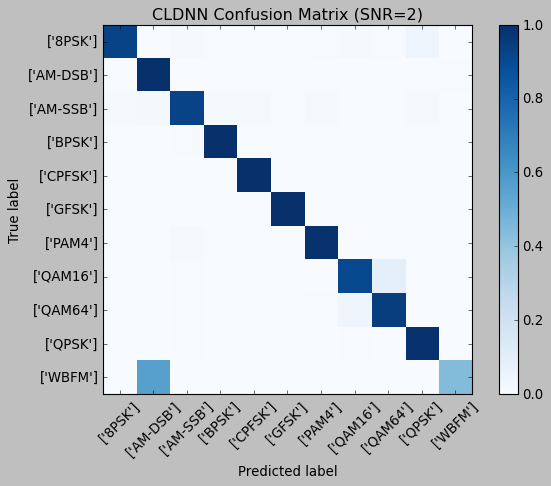

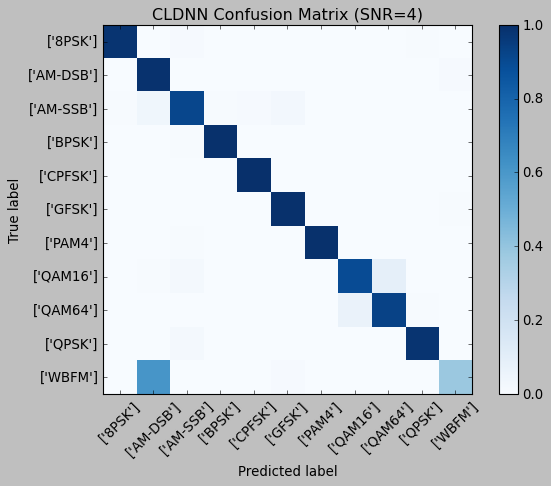

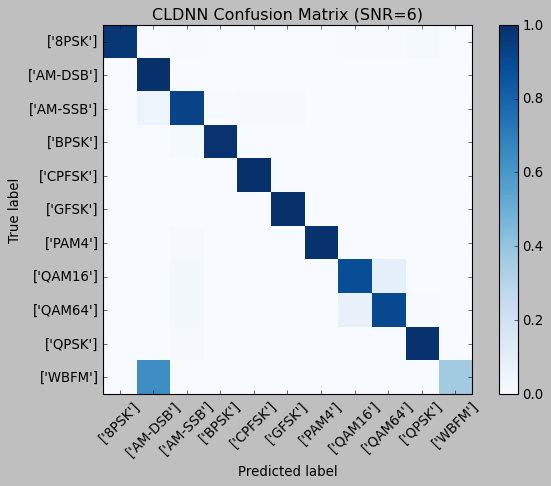

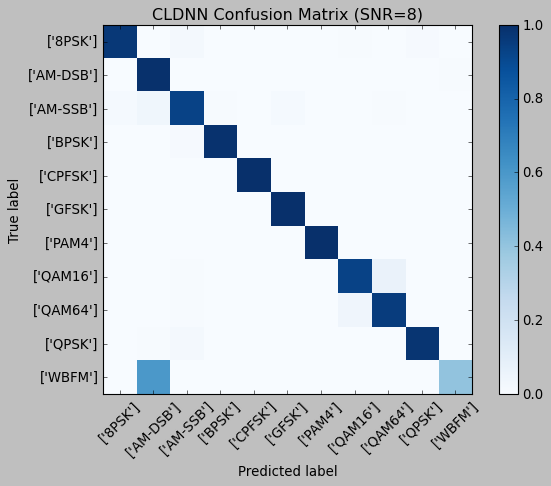

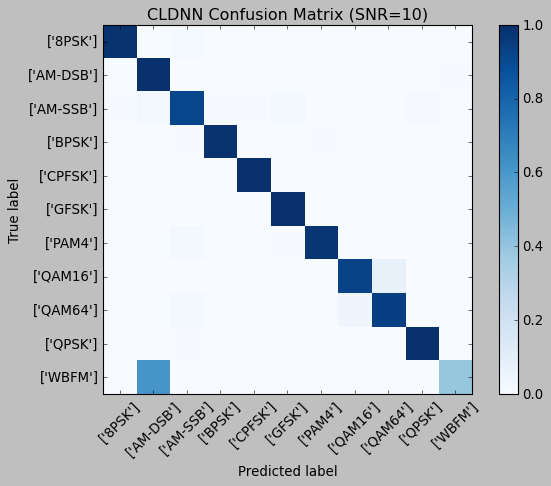

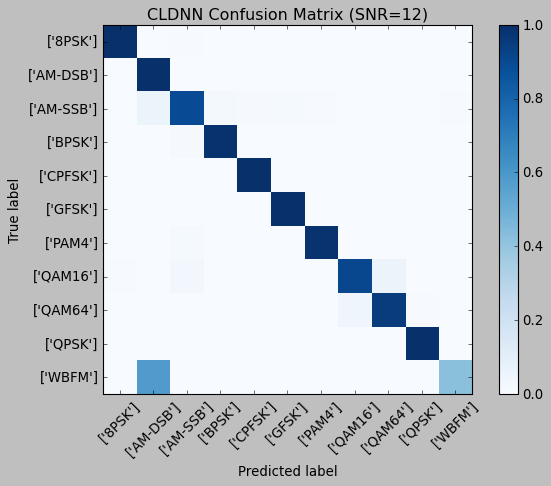

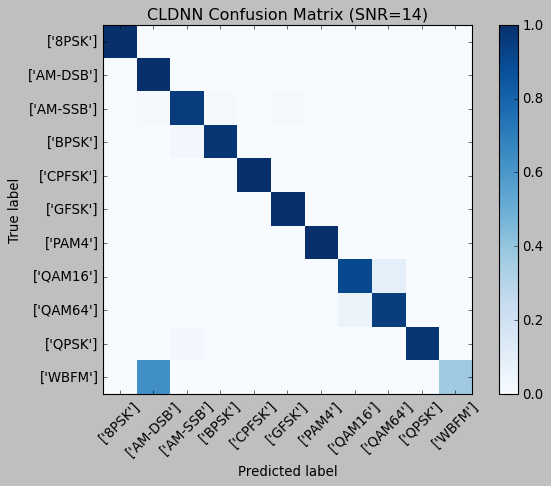

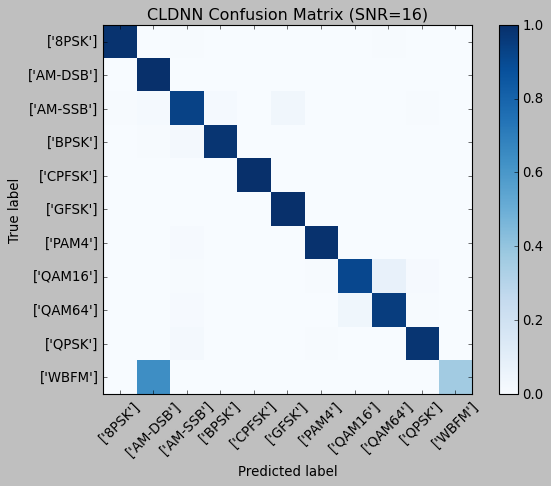

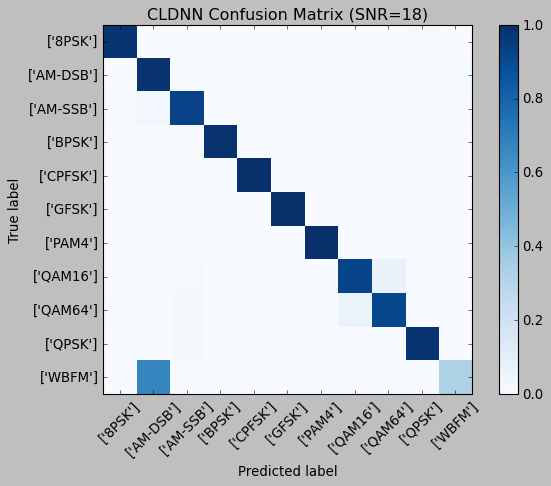

In [72]:
acc = {}
snr = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

for snr in snrs:
    temp_np = np.array(temp[snr])
    lbl_np = np.array(lb[snr])
    
    #temp_np = temp_np.reshape(temp_np.shape[0], temp_np.shape[1], temp_np.shape[2], 1)
    lbl_np = lbl_np.reshape(lbl_np.shape[0], 1)
    
    temp_i = np.random.choice(temp_np.shape[0], 2000, replace = False)
    test_X_i = temp_np[temp_i]
    test_Y_i = lbl_np[temp_i]   
    
    test_Y_i = enc.transform(test_Y_i).toarray()

    test_X_i = np.transpose(test_X_i[:,:,:],(0,2,1))
    # estimate classes
    test_Y_i_hat = model_cldnn.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = (test_Y_i[i,:].tolist()).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="CLDNN Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    accuracy_dl=(cor/(cor+ncor))
    print("Overall Accuracy: ", accuracy_dl)
    acc[snr] = 1.0*cor/(cor+ncor)
    print(acc[snr])

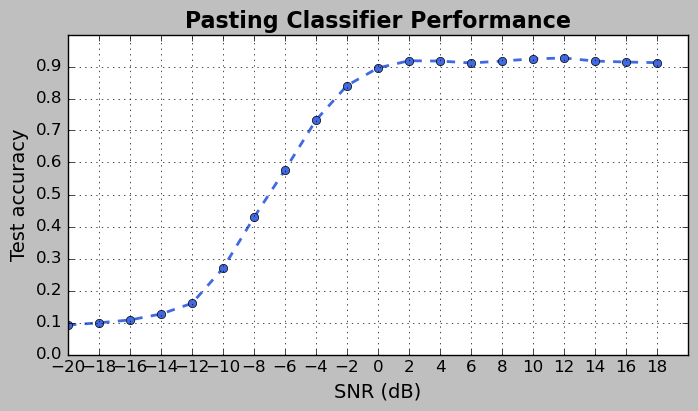

In [80]:
import collections
accuracy_dl = defaultdict(list)
accuracy_dl = collections.OrderedDict(sorted(acc.items()))
plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y5=list(accuracy_dl.values())
plt.plot(x, y5, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('DNN Classifier Performance', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

# COMPARISION OF FOUR ML CLASSIFIERS AND DNN CLASSIFIER

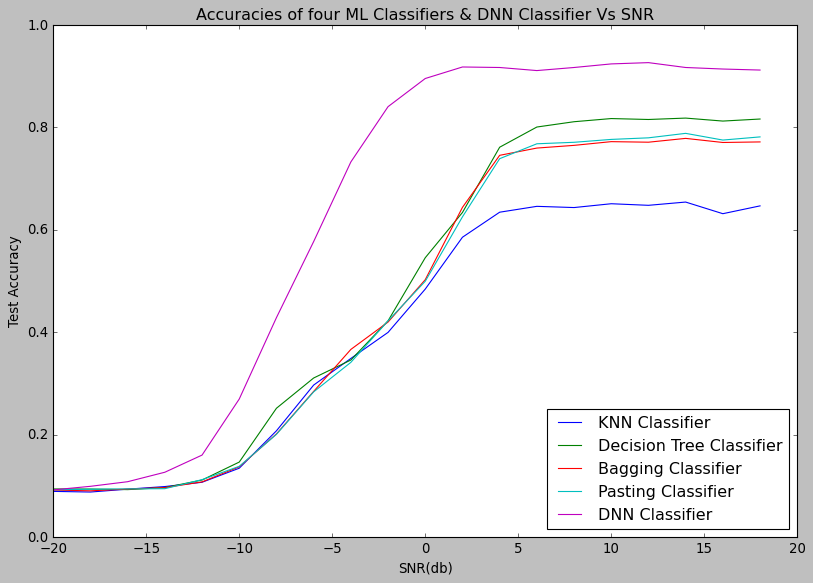

In [110]:
plt.figure(figsize=(12,8))
plt.plot(x,y1,label='KNN Classifier')
plt.plot(x,y2,label='Decision Tree Classifier')
plt.plot(x,y3,label='Bagging Classifier')
plt.plot(x,y4,label='Pasting Classifier')
plt.plot(x,y5,label='DNN Classifier')
plt.axis([-20, 20, 0, 1])
plt.title('Accuracies of four ML Classifiers & DNN Classifier Vs SNR')
plt.xlabel('SNR(db)')
plt.ylabel('Test Accuracy')
plt.legend(loc="lower right")
plt.show( )